# Project Incognito: Efficient Full-Domain K-Anonymity

## Data Set : https://www.kaggle.com/datasets/prasad22/healthcare-dataset

### Group: Abdolhamid Livani (5437973) & Arshia Navabakbar(5624621)

Several organizations publish microdata for purposes such as public health and demographic research. Although attributes that explicitly identify individuals, such as names and Social Security Numbers, are typically removed, these databases can sometimes be cross-referenced with other public databases using attributes like Zipcode, Sex, and Birthdate to reidentify individuals who were meant to remain anonymous. These "joining" attacks are facilitated by the availability of other complementary databases online.

K-anonymization is a technique designed to prevent such joining attacks by generalizing and/or suppressing parts of the released microdata so that no individual can be uniquely identified from a group of size k. This paper presents a practical framework for implementing one model of k-anonymization called full-domain generalization. We introduce a set of algorithms that produce minimal full-domain generalizations and demonstrate that these algorithms are up to an order of magnitude faster than previous ones when applied to two real-life databases.

In addition to full-domain generalization, numerous other models have been proposed for k-anonymization. The second contribution of this paper is a comprehensive taxonomy that categorizes these previous models and introduces some promising new alternatives.

In [259]:
import json
from datetime import datetime
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [260]:
# Specify the path to your CSV file
file_path = 'healthcare_dataset.csv'

with open(file_path, mode='r') as file:
    csv_content = file.read()

In [261]:

# Read the contents of the CSV file into a DataFrame
data = pd.read_csv('healthcare_dataset.csv')

print("Basic Information:")
print(data.info())

print("\nFirst 5 Rows:")
print(data.head())

print("\nSummary Statistics (Numerical Columns):")
print(data.describe())

print("\nSummary Statistics (Categorical Columns):")
print(data.describe(include=['object']))

print("\nColumn Headers:")
print(data.columns.tolist())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medication          55500 non-null  object 
 5   Insurance Provider  55500 non-null  object 
 6   Admission Type      55500 non-null  object 
 7   Medical Condition   55500 non-null  object 
 8   Date of Admission   55500 non-null  object 
 9   Doctor              55500 non-null  object 
 10  Hospital            55500 non-null  object 
 11  Billing Amount      55500 non-null  float64
 12  Room Number         55500 non-null  int64  
 13  Discharge Date      55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12

# Incognito Algorithem
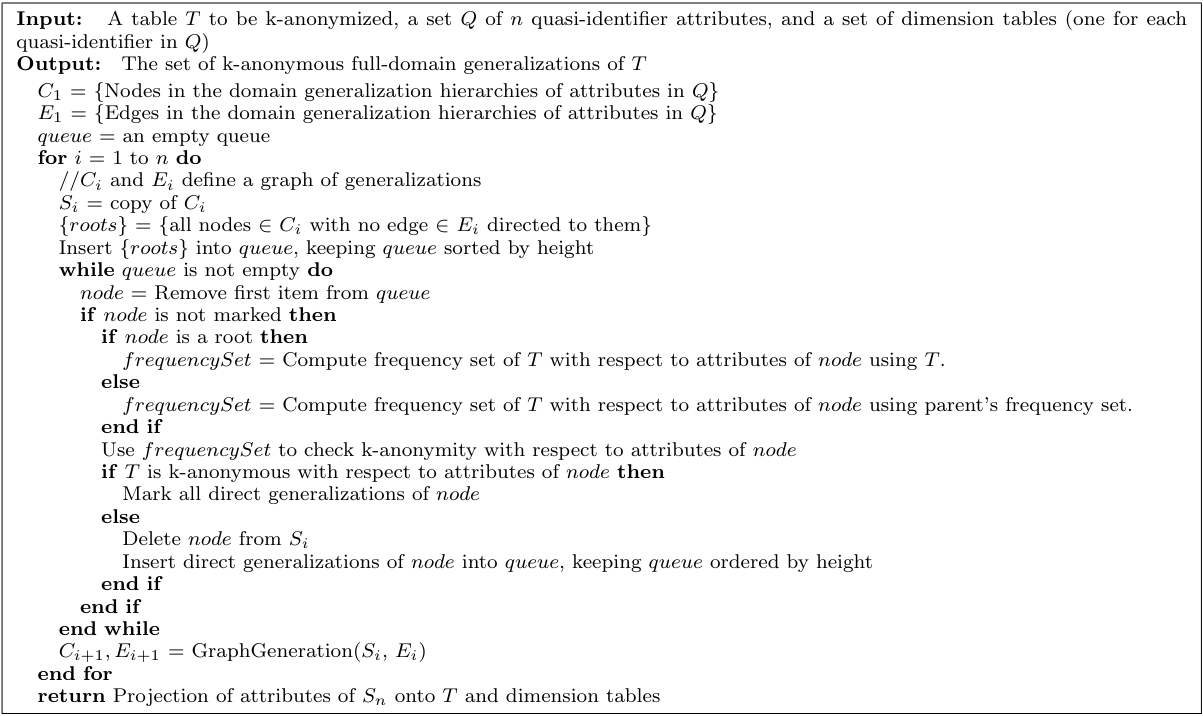

In [262]:

# Print the first few characters of the string to verify
print(csv_content[:500])

Name,Age,Gender,Blood Type,Medication,Insurance Provider,Admission Type,Medical Condition,Date of Admission,Doctor,Hospital,Billing Amount,Room Number,Discharge Date,Test Results
Bobby JacksOn,30,Male,B-,Paracetamol,Blue Cross,Urgent,Cancer,1/31/2024,Matthew Smith,Sons and Miller,18856.28131,328,2/2/2024,Normal
LesLie TErRy,62,Male,A+,Ibuprofen,Medicare,Emergency,Obesity,8/20/2019,Samantha Davies,Kim Inc,33643.32729,265,8/26/2019,Inconclusive
DaNnY sMitH,76,Female,A-,Aspirin,Aetna,Emergency,Obes


In [263]:
# Parse dataset
data = [line.split(',') for line in csv_content.strip().split('\n')]
headers = data[0]
data = data[2:]


In [264]:
# Create dimension_tables
dimension_tables = {
    "Medical Condition": {
        "0": ['Diabetes', 'Asthma','Hypertension','Obesity','Cancer','Arthritis'],
        "1": ['Diabete*', 'Asthm*', 'Hypertensio*', 'Obesit*', 'Cance*', 'Arthriti*'],
        "2": ['type1', 'type1', 'type2', 'type2', 'type3', 'type3']
    },
    "Gender": {
        "0": ["Male", "Female"],
        "1": ["Person", "Person"]
    },
    "Blood Type": {
        "0": ['O+', 'AB-', 'O-', 'AB+', 'A-', 'B-', 'B+', 'A+'],
        "1": ['O*', 'AB*', 'O*', 'AB*', 'A*', 'B*', 'B*', 'A*'],
        "2": ['O', 'AB', 'O', 'AB', 'A', 'B', 'B', 'A']
    },
    "Age": {
            
        "0": [
            '13', '14', '15', '16', '17', '18', 
            '19', '20', '21', '22', '23', '24','25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
            '36','37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
            '57', '58', '59', '60','61', '62', '63', '64', '65', '66', 
            '67', '68', '69', '70', '71', '72','73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84',
            '85', '86', '87', '88', '89'
        ],
        "1": [
            '0-18', '0-18', '0-18', '0-18', '0-18', '0-18', 
            '19-35', '19-35', '19-35', '19-35', '19-35', '19-35', '19-35', '19-35', '19-35', 
            '19-35', '19-35', '19-35', '19-35', '19-35', '19-35', '19-35', '19-35', '19-35', 
            '36-50', '36-50', '36-50', '36-50', '36-50', '36-50', '36-50', '36-50', '36-50', 
            '36-50', '36-50', '36-50', '36-50', '36-50', '36-50', '36-50', '36-50', '36-50', 
            '51-65', '51-65', '51-65', '51-65', '51-65', '51-65', '51-65', '51-65', '51-65', 
            '51-65', '51-65', '51-65', '51-65', '51-65', '51-65', '51-65', '51-65', '51-65', 
            '66+', '66+', '66+', '66+', '66+', '66+', '66+', '66+', '66+', '66+', '66+', '66+', 
            '66+', '66+', '66+', '66+', '66+', '66+'
        ],
       "2": [
            'Young', 'Young', 'Young', 'Young', 'Young', 'Young', 
            'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 
            'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 'Adult', 
            'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 
            'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 
            'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 
            'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 'Middle-aged', 
            'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 
            'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly', 'Elderly'
        ]
    },

    "Medication": {
        "0": ['Paracetamol', 'Ibuprofen', 'Aspirin', 'Penicillin', 'Lipitor'],
        "1": ['Para', 'Ibu', 'Asp.', 'Pen', 'Lip'],
        "2": ['Par-Ibu', 'Par-Ibu', 'As-Pe', 'As-Pe', 'Lip']
    },
    "Insurance Provider": {
        "0": ['Blue Cross', 'Medicare', 'Aetna', 'UnitedHealthcare', 'Cigna'],
        "1": ['BlCr', 'Medi', 'Aet', 'UnHea', 'Ci'],
        "2": ['InsType1', 'InsType1', 'InsType2', 'InsType2', 'InsType3']
    },
    "Admission Type": {
        "0": ['Urgent', 'Emergency', 'Elective'],
        "1": ['Urg.', 'Emerg.', 'Elect.'],
        "2": ['Urg-Eme', 'Urg-Eme', 'Ele']
    }
}

In [265]:
# Convert dataset to dictionary format
def convert_to_dict(data, headers):
    return [dict(zip(headers, row)) for row in data]

data_dict = convert_to_dict(data, headers)

In [266]:
# Generalize data according to dimension tables
def generalize_data(data, dimension_tables, level, quasi_identifiers):
    generalized_data = []
    for row in data:
        generalized_row = {}
        for header in headers:
            value = row[header]
            if header in dimension_tables and header in quasi_identifiers:
                max_level = max(map(int, dimension_tables[header].keys()))
                gen_level = min(level, max_level)  # Ensure level does not exceed max_level
                generalized_row[header] = dimension_tables[header][str(gen_level)][dimension_tables[header]["0"].index(value)]
            else:
                generalized_row[header] = value
        generalized_data.append(generalized_row)
    return generalized_data

In [267]:
# Check k-anonymity
def is_k_anonymous(data, k, quasi_identifiers):
    freq = defaultdict(int)
    for row in data:
        quasi_identifier = tuple(row[header] for header in quasi_identifiers)
        freq[quasi_identifier] += 1
    return all(count >= k for count in freq.values())

In [269]:
# Graph Generation
def graph_generation(Si, Ei):
    return Si, Ei
# Main incognito function
def incognito(data, dimension_tables, k, quasi_identifiers):
    Ci = {attr: list(range(len(dimension_tables[attr]))) for attr in quasi_identifiers}
    Ei = {attr: [(i, i + 1) for i in range(len(dimension_tables[attr]) - 1)] for attr in quasi_identifiers}
    queue = deque()
    
    for i in range(len(quasi_identifiers)):
        attr = quasi_identifiers[i]
        roots = [0]
        for root in roots:
            queue.append((attr, root))
    
    while queue:
        attr, node = queue.popleft()
        generalized_data = generalize_data(data, dimension_tables, node, quasi_identifiers)
        if is_k_anonymous(generalized_data, k, quasi_identifiers):
            for next_node in range(node + 1, len(dimension_tables[attr])):
                queue.append((attr, next_node))
        else:
            if node:
                Ci[attr].remove(node)
                for next_node in range(node + 1, len(dimension_tables[attr])):
                    if next_node not in queue:
                        queue.append((attr, next_node))
                    
    max_level = max(max(Ci[attr]) for attr in Ci)
    final_generalized_data = generalize_data(data, dimension_tables, max_level, quasi_identifiers)
    return final_generalized_data, max_level

In [278]:
def execute(quasi_identifiers, execution_times):
    previous_execution_time = execution_times[-1] if execution_times else 0
    
    start = datetime.now()
    generalized_data, level = incognito(data_dict, dimension_tables, 2, quasi_identifiers)
    end = datetime.now()
    
    execution_time = (end - start).total_seconds()
    
    cumulative_execution_time = execution_time + previous_execution_time
    
    execution_times.append(cumulative_execution_time)
    
    print(f"Execution time with QIs {cumulative_execution_time} seconds")
    print(f"Generalization level achieved: {level}")
    print("K-anonymous data:", generalized_data[:1])

In [281]:
def plot_execution_times(qi_sets):
    execution_times = []
    for q in qi_sets:
        execute(q, execution_times)
    plt.plot([ '3','4','5','6','7'], execution_times, marker='o')
    plt.xlabel("Quasi-Identifiers")
    plt.ylabel("Time [s]")
    plt.title("Execution Time for different QI sets with k=10")
    plt.grid()
    plt.show()

Execution time with QIs 8.384501 seconds
Generalization level achieved: 2
K-anonymous data: [{'Name': 'LesLie TErRy', 'Age': '62', 'Gender': 'Person', 'Blood Type': 'A**', 'Medication': 'Ibuprofen', 'Insurance Provider': 'Medicare', 'Admission Type': 'Emergency', 'Medical Condition': 'Obesi**', 'Date of Admission': '8/20/2019', 'Doctor': 'Samantha Davies', 'Hospital': 'Kim Inc', 'Billing Amount': '33643.32729', 'Room Number': '265', 'Discharge Date': '8/26/2019', 'Test Results': 'Inconclusive'}]
Execution time with QIs 13.045468 seconds
Generalization level achieved: 2
K-anonymous data: [{'Name': 'LesLie TErRy', 'Age': 'Middle-aged', 'Gender': 'Person', 'Blood Type': 'A**', 'Medication': 'Ibuprofen', 'Insurance Provider': 'Medicare', 'Admission Type': 'Emergency', 'Medical Condition': 'Obesi**', 'Date of Admission': '8/20/2019', 'Doctor': 'Samantha Davies', 'Hospital': 'Kim Inc', 'Billing Amount': '33643.32729', 'Room Number': '265', 'Discharge Date': '8/26/2019', 'Test Results': 'Inco

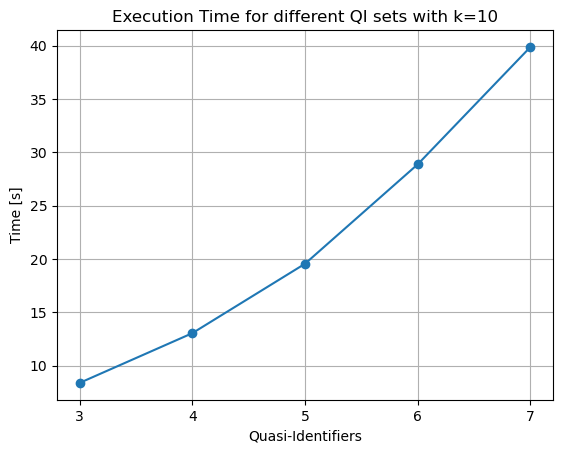

In [282]:
if __name__ == "__main__":
    qi_sets = [
               ['Medical Condition', 'Gender', 'Blood Type'], 
               ['Medical Condition','Gender', 'Blood Type','Age'],
               ['Medical Condition','Gender', 'Blood Type','Age','Medication'],
               ['Medical Condition','Gender', 'Blood Type','Age','Medication','Insurance Provider'],
               ['Medical Condition','Gender', 'Blood Type','Age','Medication','Insurance Provider','Admission Type']]
    plot_execution_times(qi_sets)